### Install dependancies and make test data

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import pandas
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from keras_tqdm import TQDMNotebookCallback
     
np.random.seed(900)     
    
N_sine    = 2       # number of sine waves to train on 
N_pts     = 100000
N_periods = 1000

pi = np.pi

dataset = np.zeros(N_pts)
times = np.linspace(start=0,stop=2.0*pi*N_periods,num=N_pts)

#make sine waves
for i in range(N_sine):
    freq = np.random.random()*1
    dataset += np.sin(2.0*pi*freq*times)
    
#add a bit of random noise 
noiselvl = .4
dataset += np.random.random(N_pts)*2*noiselvl - noiselvl

#scale to [-1, 1]
dataset = dataset*1/np.max(np.abs(dataset))

#reshape into proper shape for Keras input
dataset = np.reshape(dataset, (len(dataset),1))
    
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_foward=1):
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_foward-1):
        x = dataset[i:(i+look_back), 0]
        dataX.append(x)
        y = dataset[(i+look_back):(i+look_back+look_foward),0]
        dataY.append(y)
    return numpy.array(dataX), numpy.array(dataY)

look_back = 50
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Using Theano backend.


67000 33000


# Create and train model

In [3]:
N_LSTMs = 2

model = Sequential()
model.add(LSTM(N_LSTMs, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

model.fit(trainX, trainY, nb_epoch=100, batch_size=1000, verbose=0, callbacks=[TQDMNotebookCallback()])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_2 (LSTM)                    (None, 2)             424         lstm_input_2[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             3           lstm_2[0][0]                     
Total params: 427
____________________________________________________________________________________________________



# Make and plot predictions

/home/dan/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support 'd' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
/home/dan/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
/home/dan/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


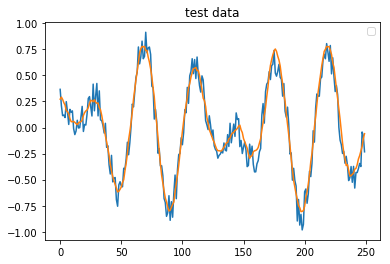

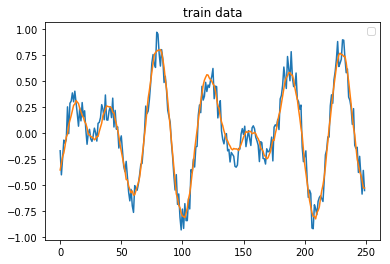

In [6]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

def make_plot(dataX, predY, title=''):
    # shift train predictions for plotting
    min2plt = look_back
    max2plt = 3*int(N_pts/N_periods)
    rng = max2plt - min2plt
    lf = look_forward
    num2plt = int(rng/lf)

    data2plt = dataX[:,0,:][min2plt:max2plt,0]
    allpreds = predY[min2plt:max2plt,:]

    pred2plt = predY[min2plt-look_back:max2plt-look_back]
    
    #pred2plt = np.zeros_like(data2plt)
    #for i in range(num2plt):
    #    pred2plt[i*lf:(i+1)*lf] = allpreds[i,:]

    #plot baseline and predictions
    plt.plot()
    plt.plot(data2plt)
    plt.plot(pred2plt)
    plt.title(title)
    plt.legend('data','predictions')
    plt.show()

make_plot(trainX, trainPredict, title='test data')
make_plot(testX,  testPredict,  title='train data')

# Now let's make the network look forward 10 

In [7]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_foward=1):
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_foward-1):
        x = dataset[i:(i+look_back), 0]
        dataX.append(x)
        y = dataset[(i+look_back):(i+look_back+look_foward),0]
        dataY.append(y)
    return numpy.array(dataX), numpy.array(dataY)

look_back = 50
look_forward = 10
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

N_LSTMs = 10

model2 = Sequential()
model2.add(LSTM(N_LSTMs, input_shape=(1, look_back)))
model2.add(Dense(look_forward))
model2.compile(loss='mean_squared_error', optimizer='adam')

model2.summary()

model2.fit(trainX, trainY, nb_epoch=100, batch_size=1000, verbose=0, callbacks=[TQDMNotebookCallback()])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_3 (LSTM)                    (None, 10)            2440        lstm_input_3[0][0]               
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 10)            110         lstm_3[0][0]                     
Total params: 2550
____________________________________________________________________________________________________



# calculate RMS error at different levels of extrapolation and print

In [11]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print('           ', end='')
for i in range(look_forward):
    print('%4i  ' % (i+1), end='')

print('\nTrain RMSE: ', end='')
trainScore = 0 
for i in range(look_forward):
    trainScore += np.sqrt(mean_squared_error(trainY[:,i], trainPredict[:,i]))
    print('%.1f ' % (trainScore), end='')
    
print('\nTest  RMSE: ', end='')    
for i in range(look_forward):
    testScore += np.sqrt(mean_squared_error(testY[:,i], testPredict[:,i]))
    print('%.1f ' % (trainScore), end='')
    

              1     2     3     4     5     6     7     8     9    10  
Train RMSE: 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 
Test  RMSE: 

NameError: name 'testScore' is not defined

# What happens if we run the LSTM network recursively? 